# История о том, как на шейкап надеялся

Фиксируем сид, что бы не было различия в результатах при прогоне из раза в раз. Так же немного стыдно за то, что не смог избавится в одном месте от 'SettingwithCopyWarning' и просто прописал в начале, что бы он игнорировался.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import os
import time

seed = 47
np.random.seed(seed)
pd.set_option('chained_assignment',None)

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/TTiDS20/zipcodes.csv
/kaggle/input/TTiDS20/test_no_target.csv
/kaggle/input/TTiDS20/sample_submission.csv
/kaggle/input/TTiDS20/train.csv


In [2]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Импортируем все данные, вначале была идея законкатить зипкоды с нашими трейн и тест сетами, сразу же дропнув дубликаты в зип кодах, но те данные лично мне не дали ничего полезного и я отложил эту идею.

In [3]:
train = pd.read_csv('/kaggle/input/TTiDS20/train.csv')
test = pd.read_csv('/kaggle/input/TTiDS20/test_no_target.csv')
zips = pd.read_csv('/kaggle/input/TTiDS20/zipcodes.csv')
sample_submission = pd.read_csv('/kaggle/input/TTiDS20/sample_submission.csv')

zips = zips.drop_duplicates(subset='zipcode')

train=train.drop(labels=['Unnamed: 0'], axis=1)
test=test.drop(labels=['Unnamed: 0'], axis=1)

print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   engine_capacity    19950 non-null  float64
 1   type               43746 non-null  object 
 2   registration_year  50000 non-null  int64  
 3   gearbox            47959 non-null  object 
 4   power              50000 non-null  int64  
 5   model              47743 non-null  object 
 6   mileage            50000 non-null  int64  
 7   fuel               46417 non-null  object 
 8   brand              50000 non-null  object 
 9   damage             41734 non-null  float64
 10  zipcode            50000 non-null  int64  
 11  insurance_price    42669 non-null  float64
 12  price              50000 non-null  int64  
dtypes: float64(3), int64(5), object(5)
memory usage: 5.0+ MB
None


In [4]:
train.head()

,engine_capacity,type,registration_year,gearbox,power,model,mileage,fuel,brand,damage,zipcode,insurance_price,price
0,2.0,bus,2006,auto,140,c4,150000,gasoline,citroen,0.0,49191,380.0,4267
1,NaN,NaN,2016,NaN,0,vito,150000,NaN,mercedes_benz,NaN,45896,NaN,2457
2,2.2,limousine,2010,manual,175,mondeo,125000,diesel,ford,0.0,59229,930.0,10374
3,NaN,NaN,2000,auto,265,andere,150000,gasoline,ford,0.0,39365,680.0,7098
4,NaN,convertible,3,manual,109,2_reihe,150000,gasoline,peugeot,0.0,55271,NaN,2365


Начал смотреть и разбирать, какие колонки есть каких типов, и если это категориальные колонки, то сколько там уникальных значений.

In [5]:
for col in train.columns:
    print(col, train[col].dtype)
print('\n')
object_cols=[]
for col in train.columns:
    if train[col].dtype=='object':
        print(col, train[col].nunique())
        object_cols.append(col)

engine_capacity float64
type object
registration_year int64
gearbox object
power int64
model object
mileage int64
fuel object
brand object
damage float64
zipcode int64
insurance_price float64
price int64


type 7
gearbox 2
model 247
fuel 5
brand 40


In [6]:
def mean_count_plot(column):
    f, axes = plt.subplots(2, figsize=(9, 9))
    mean_value=train.groupby(column)['price'].mean()
    mean_count=train.groupby(column)['price'].count()
    sns.barplot(x=mean_value.keys(), y=mean_value.values,
                    ax=axes[0]).set_title('mean_value')
    sns.barplot(x=mean_count.keys(), y=mean_count.values,
                    ax=axes[1]).set_title('mean_count')
    plt.show()

В данном фрагменте кода ориентировался на два графика: первый показывал на среднее значение таргета, если группировать по определенному значению в колонке, второй - сколько раз это значение встречается в сете.

Основная идея была убрать значения методом группировки, которые попадаются нам слишком мало раз, сгруппировав их с наиболее похожими по среднему значению таргета.

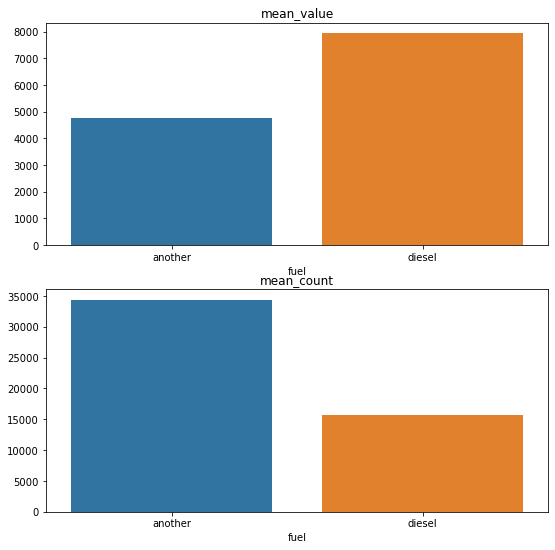

In [7]:
col='fuel'

for df in [train, test]:
    df['gearbox']=df['gearbox'].fillna('manual')
    df['fuel']=df['fuel'].fillna('empty')

    fuel_dict = {'diesel':'diesel', 'compressed natural gas':'another','empty':'another', 'gasoline':'another',
                    'liquefied petroleum gas':'another', 'other':'another'}
    df['fuel'] = df['fuel'].map(fuel_dict)

    df['type']=df['type'].fillna('empty')
    type_dict = {'bus':'bus', 'convertible':'coupé','coupé':'coupé', 'empty':'wagon',
                    'limousine':'limousine', 'other':'small car', 'small car':'small car', 'station wagon':'wagon'}
    df['type'] = df['type'].map(type_dict)


mean_count_plot(col)

In [8]:
def corr_matrix(matrix):
    corr = matrix.corr()
    plt.subplots(figsize=(10,8))
    sns.heatmap(corr,
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values,
                cmap=sns.diverging_palette(0, 200, n=200), annot=True) 
    plt.title('Correlation Heatmap of Numeric Features')

Дальше сгруппированные категорикал фичи я закидывал в КетБуст энкодер и он их преобразовывал в числовые значения методом усреднения таргета по данному значению.

In [9]:
import category_encoders as ce
from sklearn import preprocessing

cat_cols=['model','type','gearbox','fuel','brand']
target_enc = ce.CatBoostEncoder(cols=cat_cols)
target_enc.fit(train[cat_cols], train['price'])

train = train.join(target_enc.transform(train[cat_cols]).add_suffix('_cb'))
test = test.join(target_enc.transform(test[cat_cols]).add_suffix('_cb'))

train=train.drop(labels=cat_cols, axis=1)
test=test.drop(labels=cat_cols, axis=1)

Начал анализировать корр матрицу, что не дало желаемых результатов из-за слишком маленьких корреляций. Была идея работать с пропущенными данными в числовых колонках следующим образом: найти колонки с очень маленьким количеством н\а, от которых зависит другая колонка, где мы и хотим заполнить пропущенные данные. А дальше действуем линейной регрессией, тем самым заполняя пропущенные данные, предсказывая данные в колонке на основе других колонок.

In [10]:
test_na = test.dropna(subset=['damage', 'insurance_price'])
train_na = train.drop(labels=['price'], axis=1).dropna(subset=['damage', 'insurance_price'])
total_df = pd.concat([train_na, test_na], ignore_index=True)

df = pd.concat([train,test], ignore_index=True)

for col in df.columns:
    mean = df[col].mean()
    df[col] = df[col].fillna(mean)

train = df[:len(train.index)]
test = df[len(train.index):]

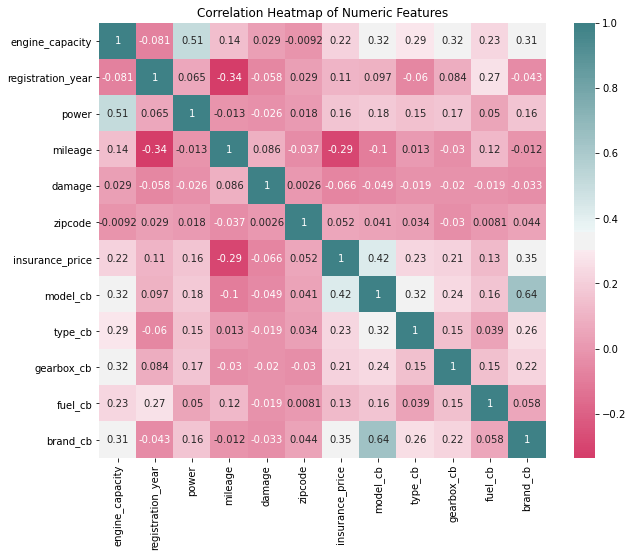

In [11]:
corr_matrix(total_df)

Использовал простейшую КВ на 5 фолдов и дефолтный хжбуст.

In [12]:
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle=True, random_state=seed)

xgb = XGBRegressor(random_state=seed)

train_num = train.drop(labels=['price','zipcode', 'engine_capacity','gearbox_cb'], axis=1)
test_num = test.drop(labels=['price','zipcode', 'engine_capacity','gearbox_cb'], axis=1)

target = train['price']

Данная функция была написана ранее, мб она не шибко оптимизирована и довольно банальна, но вот суть - дропаем по одной колонке, сравниваем КВ, идем дальше. Так ищет оптимальные колонки, которые как минимум не мешают. 

In [13]:
def feature_selection(train_num,model):

    from tqdm import tqdm

    kfold = KFold(n_splits=5, shuffle=True, random_state=seed)
    train_copy = train_num.copy()
    res_base=[]

    for i, (tdx, vdx) in enumerate(kfold.split(train_copy, target)):
        X_train, X_valid, y_train, y_valid = train_copy.iloc[tdx], train_copy.iloc[vdx], target.iloc[tdx], target.iloc[vdx]
        model.fit(X_train, y_train)
        preds=model.predict(X_valid)
        res_base.append(mean_absolute_percentage_error(y_valid,preds))

    baseline = np.mean(res_base)

    while True:
        cols = list(train_copy.columns)
        drop_rmse = []
        for drop_col in tqdm(cols):

            train_drop = train_copy.drop(labels=[drop_col], axis=1)
            res=[]

            for i, (tdx, vdx) in enumerate(kfold.split(train_copy, target)):
                X_train, X_valid, y_train, y_valid = train_drop.iloc[tdx], train_drop.iloc[vdx], target.iloc[tdx], target.iloc[vdx]
                model.fit(X_train, y_train)
                preds=model.predict(X_valid)
                res.append(mean_absolute_percentage_error(y_valid,preds))
            
            drop_rmse.append(np.mean(res))
        drop_df = pd.DataFrame(list(zip(drop_rmse, cols)), columns =['MAPE', 'Column'])
        drop_df=drop_df.sort_values(by=['MAPE'], ascending=True)
        print(drop_df.head())

        if baseline > drop_df.iloc[0, 0]:
            baseline = drop_df.iloc[0, 0]
            train_copy = train_copy.drop(labels=[drop_df.iloc[0, 1]], axis=1)
            print(f"MAPE: {round(baseline,8)}, num_cols:{len(train_copy.columns)}, dropped:{list(set(train_num.columns) - set(train_copy.columns))}") 
        else:
            print('nothing better')
            break

In [14]:
#feature_selection(train_num,xgb)

Данный блок кода сначала считает КВ по всему сету, записывает предикты, а дальше я просто выбираю аутлаеры, на которых модель не будет учиться и фильтрую их по значению разницы предикта и реального значения. Если разница больше 25к, то это аутлаер и его выбрасываем из сета. Ибо методика была в том, что бы лучше предсказывать нормальные значения и не отвлекаться на экстремальные.

29.25
True     49952
False       48
Name: price, dtype: int64


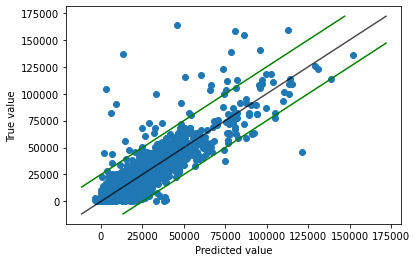

In [15]:
from sklearn.model_selection import cross_val_predict
y_pred = cross_val_predict(xgb, train_num, target, cv=5)

fig, ax = plt.subplots()
ax.scatter(y=target,x=y_pred)
ax.set_xlabel('Predicted value')
ax.set_ylabel('True value')
minimum = np.min([ax.get_xlim(), ax.get_ylim()])
maximum = np.max([ax.get_xlim(), ax.get_ylim()])
lims = [minimum, maximum]
k=25000
ax.plot(lims, lims, 'k-', alpha=0.7)
ax.plot([minimum, maximum-k], [minimum+k, maximum], 'g-')
ax.plot([minimum+k, maximum], [minimum, maximum-k], 'g-')

print(round(mean_absolute_percentage_error(target,y_pred),2))
mask = np.absolute(y_pred-target)<k
print(mask.value_counts())

Далее уже считаем КВ по нашим кфолдам, перед этим наложив маску аутлаеров. Так же делал прогон не просто на 5 фолдов, а на 40, что бы усреднить результат.

Грид сёрч по гиперпараметрам улучшения существенного не дал.

Очень помогло логарифимирование таргета ибо, как можно видеть по графику, он уж больно непропорционально распределен. 

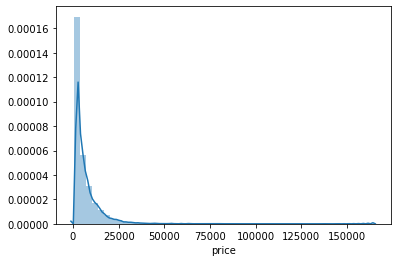

In [16]:
sns.distplot(target)

In [17]:
probs = pd.DataFrame()

train_num=train_num.loc[mask].reset_index().drop(labels=['index'], axis=1)
target=target.loc[mask].reset_index()

a = 0
res=[]
for r in range(8):

    kfold = KFold(n_splits=5, shuffle=True, random_state=r+seed)        
    for i, (tdx, vdx) in enumerate(kfold.split(train_num, target)):
        X_train, X_valid = train_num.iloc[tdx], train_num.iloc[vdx]
        y_train, y_valid = target.iloc[tdx,1], target.iloc[vdx,1]#
        xgb.fit(X_train, np.log(y_train))
        preds=xgb.predict(X_valid)
        oof_predict = xgb.predict(test_num)
        probs[f'fold_{a}'] = np.exp(oof_predict)
        res.append(mean_absolute_percentage_error(y_valid,np.exp(preds)))
        a=a+1
print(f"res:{round(np.mean(res),2)}")

probs['res_xgb'] = probs.mean(axis=1)

sample_submission['Predicted'] = probs['res_xgb']
sample_submission.to_csv('submission.csv', index=False)


res:23.3


П.С Как можно было улучшить модель? Из очевидного - нормально в данные посмотреть. Эта проблемма с неверно заполненными данными в колонках год, мощность. Так же надо было по-умнее вставлять пропущенные данные в интовых и флоат колонках...